# <u>NSW DCCEEW training – Demo 7: loading data from S3 storage</u>

 - <b>Author</b>: Eric.Lehmann@csiro.au &amp; Kesav.Unnithan@csiro.au
 - <b>Release date / version</b>: Aug. 2024, v1.0 &ndash; updated from notebook by Kesav U.
 - <b>Dev. platform</b>: CSIRO ADIAS/ADS (hub.adias.aquawatchaus.space)
 - <b>Server profile</b>: EASI Open Data Cube No ML &ndash; Version 2023.10.2 
 - <b>Server resources</b>: 32 CPU &ndash; 64GB RAM
 - <b>Python kernel</b>: `Python 3 (ipykernel)`
 - <b>Dask</b>: no cluster


# Overview

Demonstrates how to access pre-computed data saved to an S3 project bucket on EASI / ADIAS. 

This dataset represents the output from a deep-learning model used to infer water quality parameters using Landsat data.

In [1]:
import sys
import xarray as xr
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

import numpy as np

# from: https://github.com/csiro-easi/easi-notebooks.git
sys.path.append('/home/jovyan/git_hub_notebooks/scripts/')
import notebook_utils   # for xarray_object_size(), localcluster_dashboard()
# from app_utils import display_map

In [2]:
### User parameters
s3_access_path = f's3://adias-prod-dc-data-projects/nsw-outflows/DL/Clarence'   # path to S3 bucket

In [3]:
%%time

### Load entire time series
bb_wq_ds = xr.open_mfdataset(f"{s3_access_path}/*", engine='zarr', chunks={})
bb_wq_ds

CPU times: user 6.2 s, sys: 337 ms, total: 6.54 s
Wall time: 1min 13s


<xarray.Dataset>
Dimensions:      (latitude: 2000, longitude: 2334, op: 12, time: 380)
Coordinates:
  * latitude     (latitude) float64 -29.7 -29.7 -29.7 ... -29.1 -29.1 -29.1
  * longitude    (longitude) float64 153.7 153.7 153.7 ... 153.0 153.0 153.0
  * op           (op) <U9 'tss' 'doc' 'aSTRy440' ... 'aSTRp_562' 'aSTRp_654'
  * time         (time) datetime64[ns] 2013-04-11T23:44:35.538266 ... 2023-04...
Data variables:
    output_data  (latitude, longitude, op, time) float64 dask.array<chunksize=(250, 292, 3, 1), meta=np.ndarray>

In [4]:
notebook_utils.xarray_object_size( bb_wq_ds )

'Dataset size: 158.59 GB'

In [5]:
bb_wq_ds.op.values

array(['tss', 'doc', 'aSTRy440', 'Sy', 'bbpSTR550', 'Sbbp', 'temp', 'sal',
       'aSTRp_442', 'aSTRp_482', 'aSTRp_562', 'aSTRp_654'], dtype='<U9')

In [6]:
%%time

### Extract desired WQ parameters, e.g. here TSS and DOC
# Also subsample the data spatially to reduce computation / memory requirements
bb_wq_ds_wq = bb_wq_ds.output_data[::6, ::6, 0:2, :].compute()
display( notebook_utils.xarray_object_size( bb_wq_ds_wq ) )
bb_wq_ds_wq

'Dataset size: 753.36 MB'

CPU times: user 1min 8s, sys: 12 s, total: 1min 20s
Wall time: 2min 4s


<xarray.DataArray 'output_data' (latitude: 334, longitude: 389, op: 2, time: 380)>
array([[[[       nan, 0.30940151, 0.3222219 , ...,        nan,
                 nan,        nan],
         [       nan, 0.59850669, 0.57059997, ...,        nan,
                 nan,        nan]],

        [[       nan, 0.30907542, 0.3222219 , ...,        nan,
                 nan,        nan],
         [       nan, 0.59833956, 0.57915002, ...,        nan,
                 nan,        nan]],

        [[       nan, 0.3222219 , 0.3222219 , ...,        nan,
          0.3222219 ,        nan],
         [       nan, 0.60839999, 0.57915002, ...,        nan,
          0.57915002,        nan]],

        ...,

        [[       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
...
                 nan,        nan],
         [       nan, 0.57915002,        nan, ...,        nan,
                 nan,        nan]],

        ...,

        [[       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan]],

        [[       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan]],

        [[       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan]]]])
Coordinates:
  * latitude   (latitude) float64 -29.7 -29.7 -29.7 -29.69 ... -29.1 -29.1 -29.1
  * longitude  (longitude) float64 153.7 153.7 153.7 153.7 ... 153.0 153.0 153.0
  * op         (op) <U9 'tss' 'doc'
  * time       (time) datetime64[ns] 2013-04-11T23:44:35.538266 ... 2023-04-1...
Attributes:
    crs:           epsg:3577
    grid_mapping:  spatial_ref

In [7]:
### Convert to Xarray Dataset with WQ parameters as data variables
bb_wq_ds1 = xr.Dataset({var: bb_wq_ds_wq.sel(op=var).drop('op') for var in bb_wq_ds_wq.op.values})
bb_wq_ds1

<xarray.Dataset>
Dimensions:    (latitude: 334, longitude: 389, time: 380)
Coordinates:
  * latitude   (latitude) float64 -29.7 -29.7 -29.7 -29.69 ... -29.1 -29.1 -29.1
  * longitude  (longitude) float64 153.7 153.7 153.7 153.7 ... 153.0 153.0 153.0
  * time       (time) datetime64[ns] 2013-04-11T23:44:35.538266 ... 2023-04-1...
Data variables:
    tss        (latitude, longitude, time) float64 nan 0.3094 0.3222 ... nan nan
    doc        (latitude, longitude, time) float64 nan 0.5985 0.5706 ... nan nan

In [8]:
### Remove empty time slices
bb_wq_ds1 = bb_wq_ds1.dropna('time', how='all')
bb_wq_ds1

<xarray.Dataset>
Dimensions:    (latitude: 334, longitude: 389, time: 363)
Coordinates:
  * latitude   (latitude) float64 -29.7 -29.7 -29.7 -29.69 ... -29.1 -29.1 -29.1
  * longitude  (longitude) float64 153.7 153.7 153.7 153.7 ... 153.0 153.0 153.0
  * time       (time) datetime64[ns] 2013-04-27T23:44:16.800470 ... 2023-04-1...
Data variables:
    tss        (latitude, longitude, time) float64 0.3094 0.3222 nan ... nan nan
    doc        (latitude, longitude, time) float64 0.5985 0.5706 nan ... nan nan

In [9]:
### Filter out outliers...
percentile_10_1 = bb_wq_ds1.quantile(0.1, dim='time')
percentile_90_1 = bb_wq_ds1.quantile(0.9, dim='time')
bb_wq_ds1 = bb_wq_ds1.where((bb_wq_ds1 >= percentile_10_1) & (bb_wq_ds1 <= percentile_90_1))

median_ds = bb_wq_ds1.median(dim='time')

/env/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


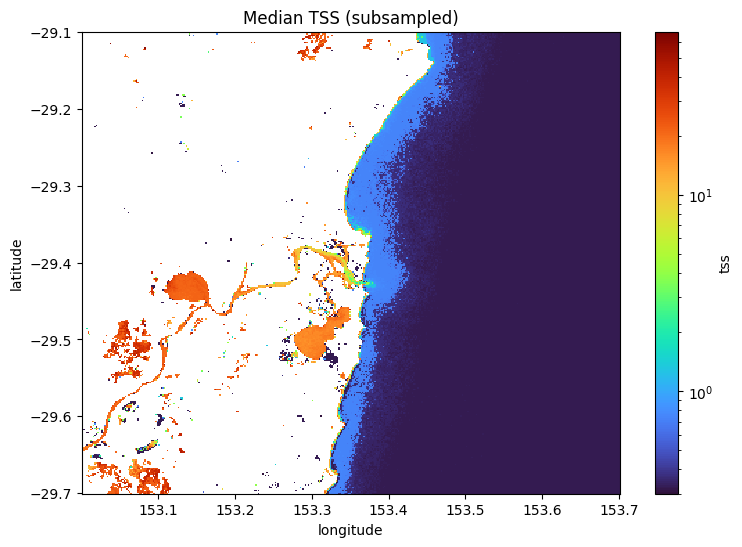

In [10]:
median_ds.tss.plot.imshow(figsize=(9, 6), norm=LogNorm(), cmap='turbo')
plt.gca().set_title('Median TSS (subsampled)');
plt.gca().set_aspect('equal','box');

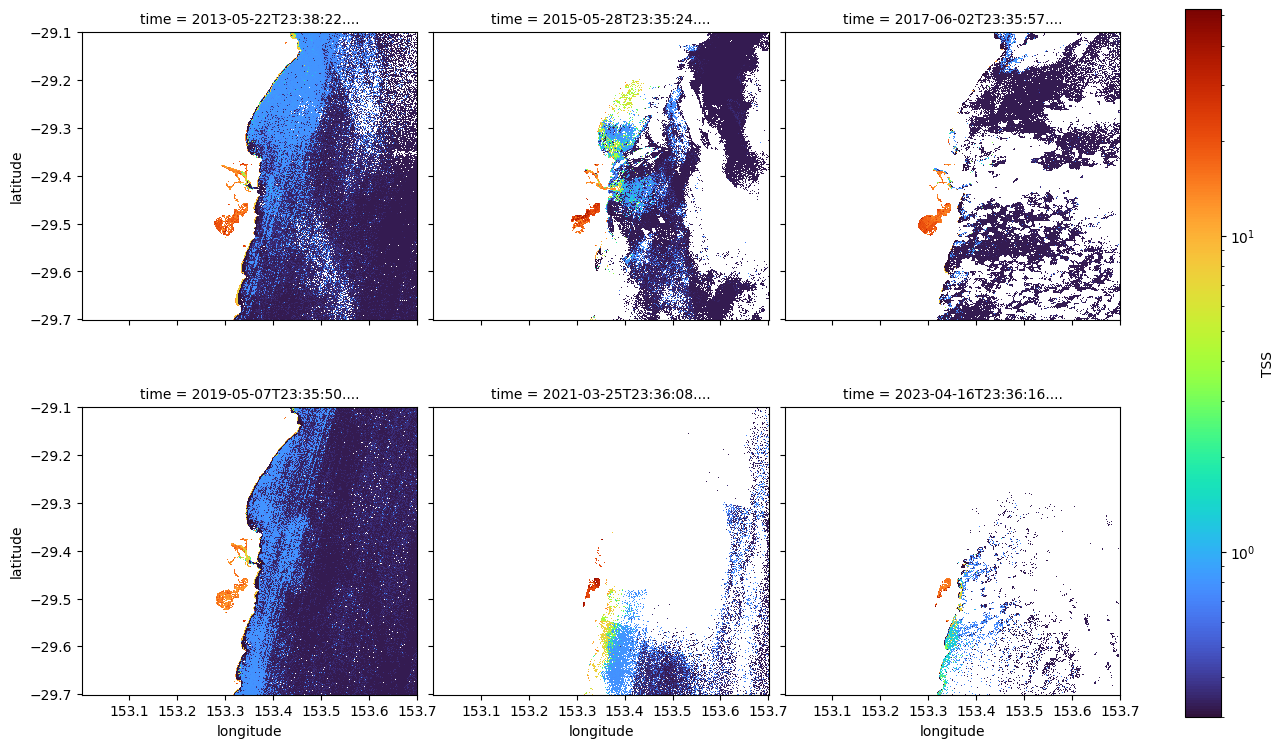

In [11]:
plt_ind = np.linspace(2, bb_wq_ds1.sizes['time'], 6, dtype='int') - 1   # some selected time slices to display
pp = bb_wq_ds1.tss[:,:,plt_ind].plot( col='time', col_wrap=3, figsize=(14,8), norm=LogNorm(), cmap='turbo', cbar_kwargs={'label': 'TSS'} )

for ii,ax in enumerate(pp.axs.flat): ax.set_aspect('equal','box')

In [12]:
### End notebook